In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [8]:
def feature_selection(data, top_attribute,label):
    data = data.dropna()
    predictors = data.loc[:, data.columns != label]
    class_label = data.loc[:, data.columns == label]
    
    # apply SelectKBest class to extract top 10 best features
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    bestfeatures = SelectKBest(score_func=f_regression, k=5)
    fit = bestfeatures.fit(predictors, class_label)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(predictors.columns)
    
    # concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    
    # naming the dataframe columns
    featureScores.columns = ['Predictors','Score']  
    
    # print 10 best features
    ranked_features = featureScores.sort_values(by='Score',ascending=False)
    ranked_features = ranked_features.reset_index()
    ranked_features = ranked_features.drop(['index'], axis = 1)
    column_names = ranked_features['Predictors'].tolist()[:top_attribute]+[label]
    
    # creating columns names for the selected features
    data = data.reset_index()
    top_attributes_list = ['Date']
    top_attributes_list.extend(column_names)
    top_attributes_list.extend([label])
    
    # create dataframe of the selected features
    data = data[top_attributes_list]
    data = data.set_index('Date')
    return column_names

In [85]:
def calculate_rmse(dataset, algorithm, test_size, top_attribute):
    data = dataset[feature_selection(dataset, top_attribute, label='PCI')]
    X = data.iloc[:-1,:-1].values
    y = data.iloc[:-1,-1:].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42,shuffle=True)
    
    if algorithm == 'AdaBoost':
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import AdaBoostRegressor
        regr = AdaBoostRegressor(random_state=0, n_estimators=100)
        regr.fit(X_train, y_train)
        predict = regr.predict(X_test)
        
    elif algorithm == 'Random Forest':
        from sklearn.ensemble import RandomForestRegressor
        regr = RandomForestRegressor(max_depth=2, random_state=0)
        regr.fit(X_train, y_train)
        predict = regr.predict(X_test)
        
    elif algorithm == 'XGBoost':
        from xgboost import XGBRegressor
        regr = XGBRegressor(objective='reg:squarederror')
        regr.fit(X_train, y_train)
        predict = regr.predict(X_test)
        
    elif algorithm == 'Bagging':
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import BaggingRegressor
        regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
        regr.fit(X_train, y_train)
        predict = regr.predict(X_test)
    
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(y_test, predict, squared=False)
    
    train_size_percent = (1-test_size)*100
    test_size_percent = test_size*100
    
    print('The', algorithm, 'RMSE for Random', str(int(train_size_percent)) + ':' + str(int(test_size_percent)), 'Percentage Split is', rmse)

In [86]:
def predict_using_random_percentage_split(dataset, algorithm, test_size, top_attribute):
    data = dataset[feature_selection(dataset, top_attribute, label='PCI')]
    X = data.iloc[:-1,:-1]
    y = data.iloc[:-1,-1:]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42,shuffle=True)
    
    X_future = data.iloc[-1:, :-1]
    y_future = data.iloc[-1:, -1:]
    
    if algorithm == 'AdaBoost':
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import AdaBoostRegressor
        regr = AdaBoostRegressor(random_state=0, n_estimators=100)
        regr.fit(X_train, y_train)      
        
        
    elif algorithm == 'Random Forest':
        from sklearn.ensemble import RandomForestRegressor
        regr = RandomForestRegressor(max_depth=2, random_state=0)
        regr.fit(X_train, y_train)
        
    elif algorithm == 'XGBoost':
        from xgboost import XGBRegressor
        regr = XGBRegressor(objective='reg:squarederror')
        regr.fit(X_train, y_train)
        
    elif algorithm == 'Bagging':
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import BaggingRegressor
        regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
        regr.fit(X_train, y_train)
    
    prediction_train = list([X_train.index, regr.predict(X_train).astype(int).tolist()])
    prediction_test = list([X_test.index,regr.predict(X_test).astype(int).tolist()])
    prediction_future = list([X_future.index, regr.predict(X_future).astype(int).tolist()])
    
    train_df  = pd.DataFrame(prediction_train).T.rename(columns={0:'Date',1:'Predictions'}).sort_values('Date').set_index('Date')
    test_df   = pd.DataFrame(prediction_test).T.rename(columns={0:'Date',1:'Predictions'}).sort_values('Date').set_index('Date')
    future_df = pd.DataFrame(prediction_future).T.rename(columns={0:'Date',1:'Predictions'}).sort_values('Date').set_index('Date')
    
    predictions = []
    predictions = train_df.append(test_df.append(future_df)).sort_index()

    data['Predictions'] = pd.DataFrame(predictions, index=predictions.index)
    return data

In [87]:
def plot_time_series(data, title):
    data = data.reset_index()
    plt.plot_date(data['Date'], data['PCI'], color = 'black', marker = 'o', label = 'actual', linestyle = '-')
    plt.plot_date(data['Date'], data['Predictions'], color = 'red', marker = 'o', label = 'predict', linestyle = '--')
    plt.legend()
    plt.grid()
    plt.xlabel('\nDate')
    plt.ylabel('RM (millions)\n')
    plt.title('Prediction of Real Private Consumption using ' + str(title))

In [88]:
adaboost_df      = pd.read_csv('AdaBoost Dataset.csv',parse_dates=[0])
xgboost_df       = pd.read_csv('XGBoost Dataset.csv',parse_dates=[0])
bagging_df       = pd.read_csv('Bagging Dataset.csv',parse_dates=[0])
random_forest_df = pd.read_csv('Random Forest Dataset.csv',parse_dates=[0])

adaboost_df      = adaboost_df.set_index('Date')
xgboost_df       = xgboost_df.set_index('Date')
bagging_df       = bagging_df.set_index('Date')
random_forest_df = random_forest_df.set_index('Date')

---------------------------------------------------------------------
Calculating RMSE
---------------------------------------------------------------------
The Bagging RMSE for Random 90:10 Percentage Split is 3364.071662930705
---------------------------------------------------------------------
Modelling and Predict Future Values
---------------------------------------------------------------------


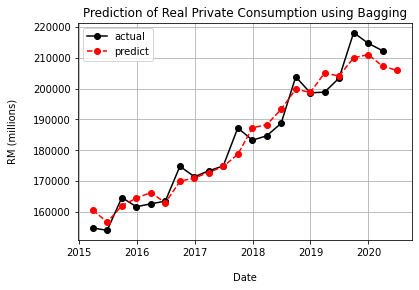

In [90]:
dataset = bagging_df
title   = "Bagging"
print('---------------------------------------------------------------------')
print('Calculating RMSE')
print('---------------------------------------------------------------------')
calculate_rmse(dataset, algorithm, test_size=0.10, top_attribute=10)
print('---------------------------------------------------------------------')
print('Modelling and Predict Future Values')
data = predict_using_random_percentage_split(dataset, algorithm=title, test_size=0.10, top_attribute=10)
print('---------------------------------------------------------------------')
plot_time_series(data,title=title)

---------------------------------------------------------------------
Calculating RMSE
---------------------------------------------------------------------
The Bagging RMSE for Random 90:10 Percentage Split is 4812.986656259641
---------------------------------------------------------------------
Modelling and Predict Future Values
---------------------------------------------------------------------


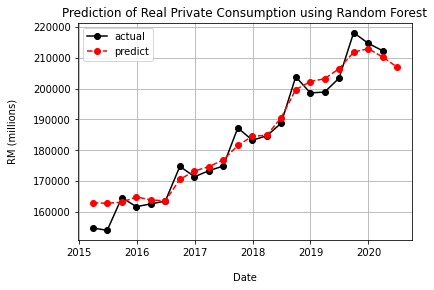

In [91]:
dataset = random_forest_df
title   = "Random Forest"
print('---------------------------------------------------------------------')
print('Calculating RMSE')
print('---------------------------------------------------------------------')
calculate_rmse(dataset, algorithm, test_size=0.10, top_attribute=7)
print('---------------------------------------------------------------------')
print('Modelling and Predict Future Values')
data = predict_using_random_percentage_split(dataset, algorithm=title, test_size=0.10, top_attribute=7)
print('---------------------------------------------------------------------')
plot_time_series(data,title=title)

---------------------------------------------------------------------
Calculating RMSE
---------------------------------------------------------------------
The Bagging RMSE for Random 90:10 Percentage Split is 3965.2427731476873
---------------------------------------------------------------------
Modelling and Predict Future Values
---------------------------------------------------------------------


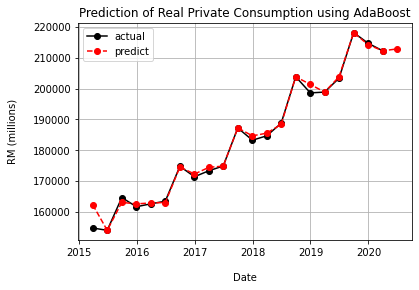

In [93]:
dataset = adaboost_df
title   = "AdaBoost"
print('---------------------------------------------------------------------')
print('Calculating RMSE')
print('---------------------------------------------------------------------')
calculate_rmse(dataset, algorithm, test_size=0.10, top_attribute=15)
print('---------------------------------------------------------------------')
print('Modelling and Predict Future Values')
data = predict_using_random_percentage_split(dataset, algorithm=title, test_size=0.10, top_attribute=15)
print('---------------------------------------------------------------------')
plot_time_series(data,title=title)

---------------------------------------------------------------------
Calculating RMSE
---------------------------------------------------------------------
The Bagging RMSE for Random 60:40 Percentage Split is 7873.265443681336
---------------------------------------------------------------------
Modelling and Predict Future Values
---------------------------------------------------------------------


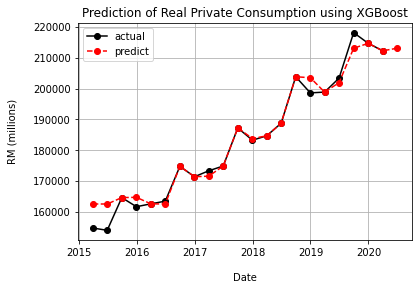

In [94]:
dataset = xgboost_df
title   = "XGBoost"
print('---------------------------------------------------------------------')
print('Calculating RMSE')
print('---------------------------------------------------------------------')
calculate_rmse(dataset, algorithm, test_size=0.40, top_attribute=12)
print('---------------------------------------------------------------------')
print('Modelling and Predict Future Values')
data = predict_using_random_percentage_split(dataset, algorithm=title, test_size=0.40, top_attribute=12)
print('---------------------------------------------------------------------')
plot_time_series(data,title=title)